# Pokémon Quantum fight

## Table of Contents

* [Pre-requisites](#chap0)
* [The idea](#idea)
* [The game](#game)
    * [General processes](#general_process)
* [Artificial Intelligence](#ai)
    * [Strategy](#strategy)
    * [Grover's algorithm](#grover)
    * [QRAM](#qram)
    * [General algorithm](#algorithm)
* [And now?](#then)
* [References](#references)

## Pre-requisites <a class="anchor" id="chap0"></a>
Before starting, we need to install Qiskit, for which we need to execute the following cell:

In [ ]:
%pip install qiskit
%pip install qiskit[visualization]
%pip install numpy
%pip install matplotlib

To test your installation:

In [ ]:
import math
from random import *
from IPython.display import Image, display, YouTubeVideo
import numpy as np
import qiskit
from qiskit import Aer, QuantumCircuit, execute, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector
qiskit.__qiskit_version__

In order to initialize our quantum computer just run the following cell:

In [ ]:
# Initialize Qasm simulator backend
qasm = Aer.get_backend('qasm_simulator')

# Initialize Real Quantum computer
# If you run qiskit on a real computer for the first time, you will need to create an account on https://quantum-computing.ibm.com/login
# and run the following line with you token.
#IBMQ.save_account('MY_API_TOKEN')

IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quantum_computer = provider.get_backend('ibmq_16_melbourne')

# Here we will use the local simulator --> Aer
backend_sim = qasm  # Choose your backend : <quantum_computer> or <qasm>

## Idea behind <a class="anchor" id="idea"></a>
The main idea of this game code came due to Nostalgia. If you were born in the 90's you certainly played the first Pokémon games, Red and Blue (not you Yellow) and, of course, you would remeber the opening of the game:

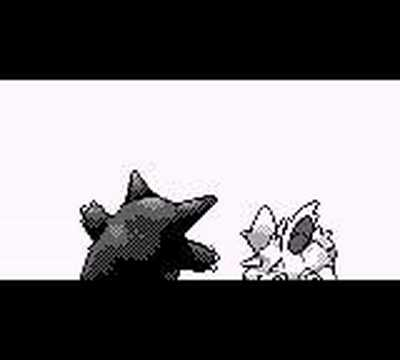

In [44]:
YouTubeVideo('C19O5xm51dk')

This first fight gave me the idea of doing this program, but with a quantumification of every process and a possibility of giving the opponent a quantum AI of sorts.
Here, in this post, I'll not go deep into the classical framework, but mainly into the quantum processes.

## The game <a class="anchor" id="game"></a>
The game is executed by Python programming and consists of:
- initialization of the objects
    - choice of quantum backend
    - types
    - attacks
    - Pokémon
    - players
    - fight
    - team creation
    - choice of action -> attack or switch (quantum)
        - if attack -> choice of attack (quantum)
        - if switch -> choice of Pokémon switch (quantum)
    - choice of who attacks first by the level of speed
    - whether choice of speeds of both Pokémon are the same (quantum)
    - precision of the attack (quantum)
    - critical attack (quantum)
    - applying condition -> poison / paralyze / burn / freeze (quantum)
    - choice of next Pokémon if AI Pokémon is K.O. (quantum)

We perform every probability calculations and opponent decision(s) by quantum processes. The perfect structure could be illustrated as:

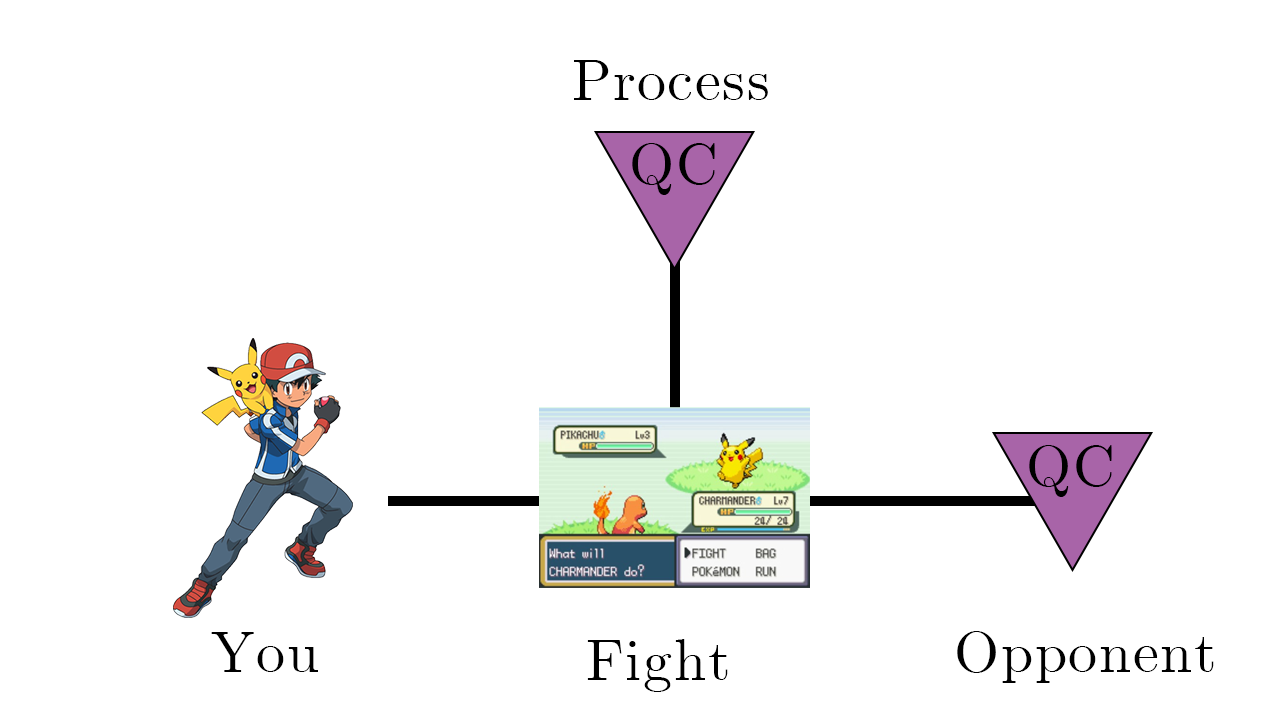

In [45]:
Image("images_jupyter/structure.png", width="700")

### General processes <a class="anchor" id="general_process"></a>
As shown in my illustration above, I use the same quantum computer for all of my probability calculations and as the only difference between these calculations are the probabilities of occurences, I just use the same circuit but with a different angle of theta (rotation).

#### Precision / Critical / Condition / Speed draw
- When a Pokémon declares an attack, the first thing to do is to check if the attack can affect the opponent. This is done by doing a check on the accuracy of the move. We call this number $\psi$ (say $psi$) and then I'm creating a qubit and appling a quantum rotation gate of angle $\pi*\psi$.

If the accuracy is $100\%$, my qubit will flip from 0 to 1, thus the attack affects the target. If the attack has an accuracy of $70\%$, the qubit will be in a superposition and its the role of the measurement to "choose" if the qubit will collapse to the state 0 or go to state 1.


- Next, we check the probability of critical attack, apart from some exceptions this number is always the same, approximately $4\%$ ($4.17\%$). With this number we'll apply the same transformation as the accuracy check.


- Finally, we check if the move is of fire, poison, electric or ice type. If so, we apply to a qubit a transformation of the respective accuracy ($10\%$, $30\%$, $30\%$ and $10\%$) and see if a condition of burn, poison, paralysis or freeze will apply.


- Usually, the order of which Pokémon moves first is decided by their speed, but sometimes both have the same speed. In this case, we put a qubit in a perfect superposition by rotation by $\frac{\pi}{2}$.

In [46]:
attack = 0.7 # Accuracy of the attack, most of the attacks are of precision 100%, 90% or 70%
crit = 0.0417 # Critical 
burn = 0.1
poison = 0.3
para = 0.3
freeze = 0.1
speedtie = 0.5

qc = QuantumCircuit(1, 1)

qc.rx(math.pi * attack, 0) # The gate RX is like a NOT gate which allows us to define the angle theta and apply rotation
qc.measure(0, 0)

qc.draw()

┌───────────┐┌─┐
q_0: ┤ RX(7π/10) ├┤M├
     └───────────┘└╥┘
c: 1/══════════════╩═
                   0

Now we have our circuit. Run the following cell to read the result and see if the attack affects the opponent.

In [47]:
job = execute(qc, backend_sim, shots=1, memory=True)
result_job = job.result().get_memory()
to_return = int(result_job[0], 2)
if to_return == 1:
    print("Result : {}, the attack succeeded!".format(to_return))
else:
    print("Result : {}, the attack missed the target!".format(to_return))

Result : 0, the attack missed the target!


As you can see, most of the time the result is flipping from 0 to 1, but sometimes the superposition collapses to 0 instead.

## Artificial Intelligence <a class="anchor" id="ai"></a>
Here comes the main part of the program, the real challenge. How to program the quantum computer opponent to be a good challenger to you!?!? 
We'll try to make something "simple" so we'll not program some fancy neural network to make the computer better and better, but we "just" make it such that it knows the basic rules that each of us already know:
- type mapping
- switching or attacking

### Strategy <a class="anchor" id="strategy"></a>
To program our quantum brain, here a quick reminder of the Pokémon strategy. Every type has their weaknesses and their resistances.  When a Pokémon attacks by a move from one of it's weakness it takes double the damage and when it's attacked by a move from the set of types to which it is resistant, it takes half of the damage.
The entire type mapping are available here: https://boutique-pokemon.com/blogs/blog-pokemon/table-types-pokemon (French version).

There are different ways to program it, I am using the Vertex Cover algorithm. The principle of this algorithm is to map everything to a graph and then finding the path that can connect both of the target(s). Here I'm using this algorithm like the chair lift in a mountain, that's what connects all of the stations between with every ski slope in the middle ([example](https://geofrider.remontees-mecaniques.net/3Vallees/Meribel/TSD6_Planhomme/planplanhomme.jpg)). More information about this algorithm can be found here: https://en.wikipedia.org/wiki/Vertex_cover

That'll allow us to make our types interact with each other in something like this:

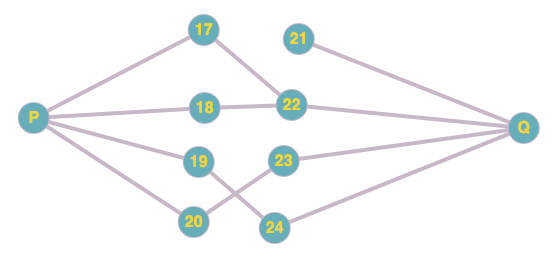

In [48]:
Image("images_jupyter/types_graph.png", width="500")

Here the alphabet vertices (P, Q) are both the fighters and the number vertices on the left are the types of the moves, indicate the type weaknesses of the fighter at right. This graph is the key to program all of the actions of our quantum computer. With this graph in mind, it'll attack with the strongest move or switch if its fighter is in a disadvantage.

#### Quantumification
Now we have a basic graph, but how can we translate it to quantum computing? We need to have a structure which gives us most of the time the best answer. Finding a structure which can have all inputs possible and give us the correct output no matter what! Here comes Grover's algorithm...

### Grover's algorithm <a class="anchor" id="grover"></a>
You may have already heard that one of the many advantages of a quantum computer is database searching speedup. Indeed that's the role of the Grover's algorithm.

#### Method
Grover's algorithm uses the amplitude amplification to identify correct solution(s). Grovers uses several inputs and with a diffuser, amplifies the inputs which match the oracle to give the output. 

Example:

In [49]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits - 1)), nqubits - 1)
    qc.h(nqubits - 1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "$Diff$"
    return U_s

algo = QuantumRegister(3, 'algo')
oracle = QuantumRegister(1, 'oracle')
c = ClassicalRegister(3, 'measurement')
qc = QuantumCircuit(algo, oracle, c)

qc.append(diffuser(3), [0, 1, 2])

qc.draw()
algo = QuantumRegister(3, 'algo')
oracle = QuantumRegister(1, 'oracle')
c = ClassicalRegister(3, 'measurement')
qc = QuantumCircuit(algo, oracle, c)

# Init
qc.h(algo)
qc.x(oracle)
qc.h(oracle)
qc.barrier()

# Algorithm
qc.mcx(algo, oracle)
qc.barrier()

# Diffuser
qc.append(diffuser(3), [0, 1, 2])

# Measure of the ouputs
qc.barrier()
qc.measure(algo, c)

qc.draw()

┌───┐      ░       ░ ┌─────────┐ ░ ┌─┐      
       algo_0: ┤ H ├──────░───■───░─┤0        ├─░─┤M├──────
               ├───┤      ░   │   ░ │         │ ░ └╥┘┌─┐   
       algo_1: ┤ H ├──────░───■───░─┤1 $Diff$ ├─░──╫─┤M├───
               ├───┤      ░   │   ░ │         │ ░  ║ └╥┘┌─┐
       algo_2: ┤ H ├──────░───■───░─┤2        ├─░──╫──╫─┤M├
               ├───┤┌───┐ ░ ┌─┴─┐ ░ └─────────┘ ░  ║  ║ └╥┘
     oracle_0: ┤ X ├┤ H ├─░─┤ X ├─░─────────────░──╫──╫──╫─
               └───┘└───┘ ░ └───┘ ░             ░  ║  ║  ║ 
measurement: 3/════════════════════════════════════╩══╩══╩═
                                                   0  1  2

- The inputs are represented by the qubits "algo_" on the top
- The algorithm is represented by the CNOT gate in the middle
- The diffuser is represented by the big block at the end
- The oracle is at the last qubit, it's in superposition state $|->$, for phase inversion of inputs which match the required conditions.

Here all our inputs are in superposition with each others, so we have something like: $\frac{|000> + |001> + |010> + ... |111>}{\sqrt{8}}$.
<br/>Then our algorithm is only an MCT gate and will be activated only if all the qubits are in state 1, so that only the inputs $|111>$ will flip the oracle qubit to add a phase of $(-1)$ to this input.
<br/>Finally our diffuser is going to read all of the inputs and if it sees an input with a negative phase, it'll amplify this input to $3 * \theta$ (or $2 * \theta$ depending on its initial amplitude and number of states).

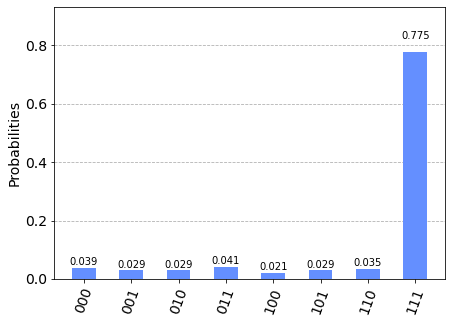

In [50]:
job = execute(qc, backend_sim, shots=512)
result_job = job.result()
plot_histogram(result_job.get_counts())

Here in our results, notice that most of the time the result is our predicted answer.

More information about Grover here:

### QRAM <a class="anchor" id="qram"></a>
First things first, how can we pass our inputs to Grover? In the general example above of using Grover, we gave it 3 random qubits, but we want to give it our list of attacks or the type of our fighter instead. To do that, we'll use a QRAM (Quantum Random Access Memory), like classical RAM. It'll allow us to map every input we want.

#### Attacks
To give an example of QRAM, we'll map all of the attack move types of our fighter:

In [51]:
# We have our Blastoise (Tortank in French) with 4 attacks : hydroblast, earthquake, ice beam, giga-impact
# We want to map all our attacks to their respective type(s) like: 
# [hydroblast : water, earthquake : ground , ice beam : ice , giga-impact : normal]

# Init register 
qram_q = QuantumRegister(2, 'qram') # We have 4 elements to map to 2 qubits are enough
normal_q = QuantumRegister(1, 'normal')
fire_q = QuantumRegister(1, 'fire')
grass_q = QuantumRegister(1, 'grass')
ground_q = QuantumRegister(1, 'ground')
fly_q = QuantumRegister(1, 'fly')
water_q = QuantumRegister(1, 'water')
elec_q = QuantumRegister(1, 'electric')
ice_q = QuantumRegister(1, 'ice')
bug_q = QuantumRegister(1, 'bug')
steel_q = QuantumRegister(1, 'steel')
qc_init = QuantumCircuit(qram_q)

# Init qubits
qc_init.h(qram_q) # Init our inputs to superposition
#qc.barrier()

qc_qram = QuantumCircuit(qram_q, normal_q, fire_q, grass_q, ground_q, fly_q, water_q, elec_q, ice_q, bug_q, steel_q, c)

# Mapping attacks
## First attack is going to be on the address 00, hydroblast
qc_qram.x(qram_q)
qc_qram.ccx(qram_q[0], qram_q[1], water_q)
qc_qram.x(qram_q)
qc_qram.barrier()
## Second attack -> 01, earthquake
qc_qram.x(qram_q[0])
qc_qram.ccx(qram_q[0], qram_q[1], ground_q)
qc_qram.x(qram_q[0])
qc_qram.barrier()
## Third attack -> 10, ice beam
qc_qram.x(qram_q[1])
qc_qram.ccx(qram_q[0], qram_q[1], ice_q)
qc_qram.x(qram_q[1])
qc_qram.barrier()
## Fourth attack -> 11, giga impact
qc_qram.ccx(qram_q[0], qram_q[1], normal_q)
qc_qram.barrier()

qc_initQram = qc_init + qc_qram
qc_initQram.draw()

┌───┐┌───┐     ┌───┐ ░ ┌───┐     ┌───┐ ░                 ░      »
       qram_0: ┤ H ├┤ X ├──■──┤ X ├─░─┤ X ├──■──┤ X ├─░────────■────────░───■──»
               ├───┤├───┤  │  ├───┤ ░ └───┘  │  └───┘ ░ ┌───┐  │  ┌───┐ ░   │  »
       qram_1: ┤ H ├┤ X ├──■──┤ X ├─░────────■────────░─┤ X ├──■──┤ X ├─░───■──»
               └───┘└───┘  │  └───┘ ░        │        ░ └───┘  │  └───┘ ░ ┌─┴─┐»
     normal_0: ────────────┼────────░────────┼────────░────────┼────────░─┤ X ├»
                           │        ░        │        ░        │        ░ └───┘»
       fire_0: ────────────┼────────░────────┼────────░────────┼────────░──────»
                           │        ░        │        ░        │        ░      »
      grass_0: ────────────┼────────░────────┼────────░────────┼────────░──────»
                           │        ░      ┌─┴─┐      ░        │        ░      »
     ground_0: ────────────┼────────░──────┤ X ├──────░────────┼────────░──────»
                           │        ░      └───┘      ░        │        ░      »
        fly_0: ────────────┼────────░─────────────────░────────┼────────░──────»
                         ┌─┴─┐      ░                 ░        │        ░      »
      water_0: ──────────┤ X ├──────░─────────────────░────────┼────────░──────»
                         └───┘      ░                 ░        │        ░      »
   electric_0: ─────────────────────░─────────────────░────────┼────────░──────»
                                    ░                 ░      ┌─┴─┐      ░      »
        ice_0: ─────────────────────░─────────────────░──────┤ X ├──────░──────»
                                    ░                 ░      └───┘      ░      »
        bug_0: ─────────────────────░─────────────────░─────────────────░──────»
                                    ░                 ░                 ░      »
      steel_0: ─────────────────────░─────────────────░─────────────────░──────»
                                    ░                 ░                 ░      »
measurement: 3/════════════════════════════════════════════════════════════════»
                                                                               »
«                ░ 
«       qram_0: ─░─
«                ░ 
«       qram_1: ─░─
«                ░ 
«     normal_0: ─░─
«                ░ 
«       fire_0: ─░─
«                ░ 
«      grass_0: ─░─
«                ░ 
«     ground_0: ─░─
«                ░ 
«        fly_0: ─░─
«                ░ 
«      water_0: ─░─
«                ░ 
«   electric_0: ─░─
«                ░ 
«        ice_0: ─░─
«                ░ 
«        bug_0: ─░─
«                ░ 
«      steel_0: ─░─
«                ░ 
«measurement: 3/═══
«

The X gate allows us to check the state of the qubit. If the qubits are on 1, the X gate is going to flip it to 0 and so the gate CCX will do nothing. If we add measurement gate(s) and analyse the result:

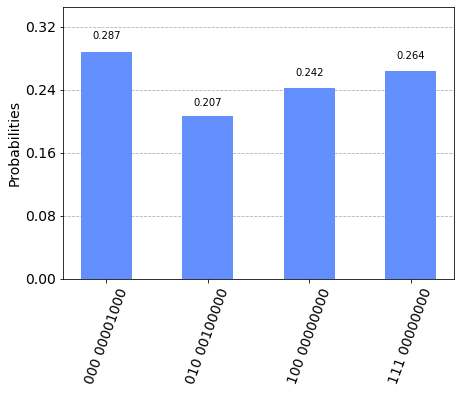

In [52]:
c = ClassicalRegister(8, 'measure')
qram_measure = QuantumCircuit(c)
qc = qc_initQram + qram_measure
qc.measure(range(8), range(8))
qc = qc.reverse_bits()
job = execute(qc, backend_sim, shots=512)
result_job = job.result()
plot_histogram(result_job.get_counts())

Here we map the attacks of our actual fighter and match with their type.

#### Switch <a class="anchor" id="switch"></a>
For switching it's similar, but we have to map all of our Pokémon on X qubits and all of their attack types. For a team of 3 Pokémon, we map the Pokémon on the first qubit(s) and the attack on the next 2 qubits.

#### Choose move <a class="anchor" id="choose"></a>
At the beginning of the post, I mentioned that the quantum computer has to choose if it has to do an attack or to switch Pokémon. To make this choice, we map the actual fighter of the opponent and see if it's type is a weakness of ours. If yes, the quantum computer will choose to switch Pokémon, else it'll choose to attack.

Now we know how to create our quantum structure, how to map our inputs and know the design of our oracle (the graph). Let's glue each part together.

### General algorithm <a class="anchor" id="algorithm"></a>
The main algorithm is the mapping algorithm and we'll use it to find the best attack move, finding the best switch to another Pokémon and to help the computer to choose if it has to attack or to switch if its current fighter is in danger. To illustrate an example, we want our computer to find the best move.
To do that we need:
- first -> give to our circuit the type of the moves our fighter knows. We did it in the above example;)
- second -> map the weakness(es) and resistance(s) of the opponent fighter
- third -> mixing weakness(es) and resistance(s) together to know whether each move is very strong or not
- last -> adding the Grover diffuser

Let's imagine, the computer fighter is a Blastoise and ours is a Charizard.
<br/>Charizard is a Fire/Flying-type Pokémon, so its weakness will be:
- Water
- Ground
- Electric
- Ice

And its resistances:
- fire
- bug
- grass
- steel
- ice
<br/>Also, Flying-type has immunity to Ground-types, which means a Flying-type Pokémon would never take any damage from a Ground move.
- Ground --> immunity

First of all, we have to map all of these parameters:

In [53]:
# Init type qubits
fire_q = QuantumRegister(1, 'fire')
grass_q = QuantumRegister(1, 'grass')
ground_q = QuantumRegister(1, 'ground')
fly_q = QuantumRegister(1, 'fly')
water_q = QuantumRegister(1, 'water')
elec_q = QuantumRegister(1, 'electrick')
ice_q = QuantumRegister(1, 'ice')
bug_q = QuantumRegister(1, 'bug')
steel_q = QuantumRegister(1, 'steel')
qc_types = QuantumCircuit(fire_q, grass_q, ground_q, fly_q, water_q, elec_q, ice_q, bug_q, steel_q)

# Init charamender
fire_weak = [water_q, ground_q]
fly_weak = [elec_q, ice_q]
fire_resist = [fire_q, bug_q, grass_q, steel_q, ice_q]
fly_resist = [grass_q, bug_q]
fire_immune = ["None"]
fly_immune = [ground_q]

# Charamenter type map
weakFire_q = QuantumRegister(1, 'weak_fire')
weakFly_q = QuantumRegister(1, 'weak_fly')
checkWeak_q = QuantumRegister(1, 'check_weak')

resistFire_q = QuantumRegister(1, 'resist_fire')
resistFly_q = QuantumRegister(1, 'resist_fly')
immuneFire_q = QuantumRegister(1, 'immunity_fire')
immuneFly_q = QuantumRegister(1, 'immunity_fly')
qc_charamender = QuantumCircuit(weakFire_q, weakFly_q, checkWeak_q, resistFire_q, resistFly_q, immuneFire_q, immuneFly_q)

qc_defenderMapping = qc_types + qc_charamender

# Apply gates
## Weakness
if fire_weak[0] != "None":
    for i in fire_weak:
        qc_defenderMapping.cx(i, weakFire_q)
if fly_weak[0] != "None":
    for i in fly_weak:
        qc_defenderMapping.cx(i, weakFly_q)
qc_defenderMapping.barrier()
## Resistances
if fire_resist[0] != "None":
    for i in fire_resist:
        qc_defenderMapping.cx(i, resistFire_q)
if fly_resist[0] != "None":
    for i in fly_resist:
        qc_defenderMapping.cx(i, resistFly_q)
qc_defenderMapping.barrier()
## Immunity
if fire_immune[0] != "None":
    for i in fire_immune:
        qc_defenderMapping.cx(i, immuneFire_q)
if fly_immune[0] != "None":
    for i in fly_immune:
        qc_defenderMapping.cx(i, immuneFly_q)

# Check of the weakness
def or_weak(qc):
    qc.barrier()
    qc.cx(weakFire_q[0], checkWeak_q[0])
    qc.cx(weakFly_q[0], checkWeak_q[0])
    qc.ccx(weakFly_q[0], weakFire_q[0], checkWeak_q[0])
    qc.barrier()
qc_orweak = qc_types + qc_charamender

or_weak(qc_orweak)

(qc_defenderMapping + qc_orweak).draw()

░                                     ░ »
         fire_0: ─────────────────────░───■─────────────────────────────────░─»
                                      ░   │                                 ░ »
        grass_0: ─────────────────────░───┼─────────■─────────■─────────────░─»
                                      ░   │         │         │             ░ »
       ground_0: ────────────■────────░───┼─────────┼─────────┼─────────────░─»
                             │        ░   │         │         │             ░ »
          fly_0: ────────────┼────────░───┼─────────┼─────────┼─────────────░─»
                             │        ░   │         │         │             ░ »
        water_0: ──■─────────┼────────░───┼─────────┼─────────┼─────────────░─»
                   │         │        ░   │         │         │             ░ »
    electrick_0: ──┼────■────┼────────░───┼─────────┼─────────┼─────────────░─»
                   │    │    │        ░   │         │         │             ░ »
          ice_0: ──┼────┼────┼────■───░───┼─────────┼─────────┼────■────────░─»
                   │    │    │    │   ░   │         │         │    │        ░ »
          bug_0: ──┼────┼────┼────┼───░───┼────■────┼─────────┼────┼────■───░─»
                   │    │    │    │   ░   │    │    │         │    │    │   ░ »
        steel_0: ──┼────┼────┼────┼───░───┼────┼────┼────■────┼────┼────┼───░─»
                 ┌─┴─┐  │  ┌─┴─┐  │   ░   │    │    │    │    │    │    │   ░ »
    weak_fire_0: ┤ X ├──┼──┤ X ├──┼───░───┼────┼────┼────┼────┼────┼────┼───░─»
                 └───┘┌─┴─┐└───┘┌─┴─┐ ░   │    │    │    │    │    │    │   ░ »
     weak_fly_0: ─────┤ X ├─────┤ X ├─░───┼────┼────┼────┼────┼────┼────┼───░─»
                      └───┘     └───┘ ░   │    │    │    │    │    │    │   ░ »
   check_weak_0: ─────────────────────░───┼────┼────┼────┼────┼────┼────┼───░─»
                                      ░ ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐  │  ┌─┴─┐  │   ░ »
  resist_fire_0: ─────────────────────░─┤ X ├┤ X ├┤ X ├┤ X ├──┼──┤ X ├──┼───░─»
                                      ░ └───┘└───┘└───┘└───┘┌─┴─┐└───┘┌─┴─┐ ░ »
   resist_fly_0: ─────────────────────░─────────────────────┤ X ├─────┤ X ├─░─»
                                      ░                     └───┘     └───┘ ░ »
immunity_fire_0: ─────────────────────░─────────────────────────────────────░─»
                                      ░                                     ░ »
 immunity_fly_0: ─────────────────────░─────────────────────────────────────░─»
                                      ░                                     ░ »
«                       ░                 ░ 
«         fire_0: ──────░─────────────────░─
«                       ░                 ░ 
«        grass_0: ──────░─────────────────░─
«                       ░                 ░ 
«       ground_0: ──■───░─────────────────░─
«                   │   ░                 ░ 
«          fly_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«        water_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«    electrick_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«          ice_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«          bug_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«        steel_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«    weak_fire_0: ──┼───░───■─────────■───░─
«                   │   ░   │         │   ░ 
«     weak_fly_0: ──┼───░───┼────■────■───░─
«                   │   ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ 
«   check_weak_0: ──┼───░─┤ X ├┤ X ├┤ X ├─░─
«                   │   ░ └───┘└───┘└───┘ ░ 
«  resist_fire_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«   resist_fly_0: ──┼───░─────────────────░─
«                   │   ░                 ░ 
«immunity_fire_0: ──┼───░─────────────────░─
«                 ┌─┴─┐ ░                 ░ 
« i

Here is the entire mapping for all of the Charizard parameters. The check weakness qubit is used to check if the move can be super effective or not. Now let's add the attack mapping.

In [ ]:
qc_algo = qc_init + qc_qram + qc_defenderMapping + qc_orweak

qc_algo.draw()

Now we have to design our oracle such that it flips when the input is a correct answer. For that we will use a CNOT gate on the check qubits, on both resist qubits and on both immune qubits too:
- The check qubit indicates if a move is strong or not against the target
- The resist qubit is in 0 and will stay in 0 if the move is strong or very strong
- The immune qubit stays in 0 if the move can cause damage to the target

For the resistance qubits and the immune qubits, we will surround them by X gates to make sure flipping occurs if they are in 0, (i.e.) it's an effective move.

In [ ]:
oracle_q = QuantumRegister(1, 'oracle')
qc_oracle = QuantumCircuit(oracle_q)
qc_oracle.x(oracle_q)
qc_oracle.h(oracle_q)

# Glueing everything together
qc_finale = qc_oracle + qc_init + qc_qram + qc_defenderMapping + qc_orweak

qc_finale.x([resistFire_q[0], resistFly_q[0], immuneFire_q[0], immuneFly_q[0]])
qc_finale.mcx([checkWeak_q, resistFire_q, resistFly_q, immuneFire_q, immuneFly_q], oracle_q)
qc_finale.x([resistFire_q[0], resistFly_q[0], immuneFire_q[0], immuneFly_q[0]])
qc_finale.barrier()

qc_finale.draw()

Now, our entire algorithm is finished, and in order to not have errors in the distribution we need to repeat in reverse the entire algorithm a second time (except the oracle part) to uncompute the whole transformation, and, finally, we just need to apply our diffuser and measurements, allowing us to finally see the result.

In [ ]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits - 1)), nqubits - 1)
    qc.h(nqubits - 1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return qc


qc_finale = qc_oracle + qc_init 
for i in range(1):
    qc_finale = qc_finale + qc_qram + qc_defenderMapping + qc_orweak

    qc_finale.x([resistFire_q[0], resistFly_q[0], immuneFire_q[0], immuneFly_q[0]])
    qc_finale.mcx([checkWeak_q, resistFire_q, resistFly_q, immuneFire_q, immuneFly_q], oracle_q)
    qc_finale.x([resistFire_q[0], resistFly_q[0], immuneFire_q[0], immuneFly_q[0]])

    qc_finale = qc_finale + qc_orweak + qc_defenderMapping + qc_qram

    qc_finale.append(diffuser(2), [1, 2])
    
qc_finale.barrier()
qc_finale.measure(qram_q, range(2))

qc_finale.draw()

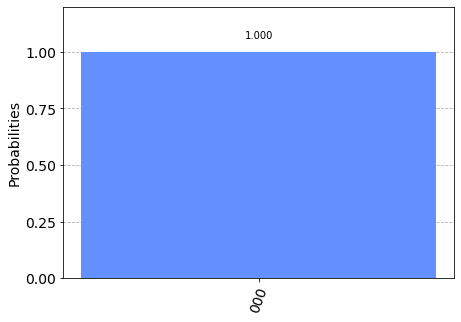

In [57]:
qc = qc_finale.reverse_bits()
job = execute(qc, backend_sim, shots=512)
result_job = job.result()
plot_histogram(result_job.get_counts())

As we can see the only answer is the attack encoded in the address 00, which denotes hydroblast, a water attack, one of the weakness(es) of Charmander. That's exactly what we wanted for our output.
<br/>Finally, the global structure of the circuit is looks like this:

In [58]:
oracle_q = QuantumRegister(1, 'oracle')
qram_q = QuantumRegister(2, 'qram')

fire_q = QuantumRegister(1, 'fire')
grass_q = QuantumRegister(1, 'grass')
ground_q = QuantumRegister(1, 'ground')
fly_q = QuantumRegister(1, 'fly')
water_q = QuantumRegister(1, 'water')
elec_q = QuantumRegister(1, 'electrick')
ice_q = QuantumRegister(1, 'ice')
bug_q = QuantumRegister(1, 'bug')
steel_q = QuantumRegister(1, 'steel')
normal_q = QuantumRegister(1, 'normal')

resistFire_q = QuantumRegister(1, 'resist_fire')
resistFly_q = QuantumRegister(1, 'resist_fly')
immuneFire_q = QuantumRegister(1, 'immunity_fire')
immuneFly_q = QuantumRegister(1, 'immunity_fly')
weakFire_q = QuantumRegister(1, 'weak_fire')
weakFly_q = QuantumRegister(1, 'weak_fly')
checkWeak_q = QuantumRegister(1, 'check_weak')

c = ClassicalRegister(2, 'measure')

qc = QuantumCircuit(oracle_q, qram_q, fire_q, grass_q, ground_q, fly_q, water_q, elec_q, ice_q, bug_q, 
                    steel_q, normal_q, resistFire_q, resistFly_q, immuneFire_q, immuneFly_q, 
                    weakFire_q, weakFly_q, checkWeak_q, c)

def qram(nqubits):
    qc = QuantumCircuit(nqubits)
    U_s = qc.to_gate()
    U_s.name = "$QRAM$"
    return U_s

def defenderMapping(nqubits):
    qc = QuantumCircuit(nqubits)
    U_s = qc.to_gate()
    U_s.name = "$mappingChara$"
    return U_s

def orweak(nqubits):
    qc = QuantumCircuit(nqubits)
    U_s = qc.to_gate()
    U_s.name = "$weakCheck$"
    return U_s

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    U_s = qc.to_gate()
    U_s.name = "$diffuser$"
    return U_s

# Init
qc.x(oracle_q)
qc.h(oracle_q)
qc.h(qram_q)
qc.barrier()

for i in range(1):
    # Qram
    qc.append(qram(12), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    # Algo
    qc.append(defenderMapping(16), [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
    qc.append(orweak(3), [17, 18, 19])

    # Oracle
    qc.barrier()
    qc.x([resistFire_q[0], resistFly_q[0], immuneFire_q[0], immuneFly_q[0]])
    qc.mcx([checkWeak_q, resistFire_q, resistFly_q, immuneFire_q, immuneFly_q], oracle_q)
    qc.x([resistFire_q[0], resistFly_q[0], immuneFire_q[0], immuneFly_q[0]])
    qc.barrier()

    # Uncompute
    qc.append(orweak(3), [17, 18, 19])
    qc.append(defenderMapping(16), [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
    qc.append(qram(12), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

    # Diffuser
    qc.append(diffuser(2), [1, 2])
    
qc.barrier()
qc.measure(qram_q, range(2))

qc.draw()

┌───┐┌───┐ ░                                                 »
       oracle_0: ┤ X ├┤ H ├─░─────────────────────────────────────────────────»
                 ├───┤└───┘ ░ ┌──────────┐                                    »
         qram_0: ┤ H ├──────░─┤0         ├────────────────────────────────────»
                 ├───┤      ░ │          │                                    »
         qram_1: ┤ H ├──────░─┤1         ├────────────────────────────────────»
                 └───┘      ░ │          │┌──────────────────┐                »
         fire_0: ───────────░─┤2         ├┤0                 ├────────────────»
                            ░ │          ││                  │                »
        grass_0: ───────────░─┤3         ├┤1                 ├────────────────»
                            ░ │          ││                  │                »
       ground_0: ───────────░─┤4         ├┤2                 ├────────────────»
                            ░ │          ││                  │                »
          fly_0: ───────────░─┤5         ├┤3                 ├────────────────»
                            ░ │   $QRAM$ ││                  │                »
        water_0: ───────────░─┤6         ├┤4                 ├────────────────»
                            ░ │          ││                  │                »
    electrick_0: ───────────░─┤7         ├┤5                 ├────────────────»
                            ░ │          ││                  │                »
          ice_0: ───────────░─┤8         ├┤6                 ├────────────────»
                            ░ │          ││                  │                »
          bug_0: ───────────░─┤9         ├┤7                 ├────────────────»
                            ░ │          ││   $mappingChara$ │                »
        steel_0: ───────────░─┤10        ├┤8                 ├────────────────»
                            ░ │          ││                  │                »
       normal_0: ───────────░─┤11        ├┤9                 ├────────────────»
                            ░ └──────────┘│                  │                »
  resist_fire_0: ───────────░─────────────┤10                ├────────────────»
                            ░             │                  │                »
   resist_fly_0: ───────────░─────────────┤11                ├────────────────»
                            ░             │                  │                »
immunity_fire_0: ───────────░─────────────┤12                ├────────────────»
                            ░             │                  │                »
 immunity_fly_0: ───────────░─────────────┤13                ├────────────────»
                            ░             │                  │┌──────────────┐»
    weak_fire_0: ───────────░─────────────┤14                ├┤0             ├»
                            ░             │                  ││              │»
     weak_fly_0: ───────────░─────────────┤15                ├┤1 $weakCheck$ ├»
                            ░             └──────────────────┘│              │»
   check_weak_0: ───────────░─────────────────────────────────┤2             ├»
                            ░                                 └──────────────┘»
      measure: 2/═════════════════════════════════════════════════════════════»
                                                                              »
«                  ░      ┌───┐      ░                                     »
«       oracle_0: ─░──────┤ X ├──────░─────────────────────────────────────»
«                  ░      └─┬─┘      ░                                     »
«         qram_0: ─░────────┼────────░─────────────────────────────────────»
«                  ░        │        ░                                     »
«         qram_1: ─░────────┼────────░─────────────────────────────────────»
«                  ░        │        ░                 ┌──────────────────┐»
«         fire_0: ─░────────┼────────░

## And now? <a class="anchor" id="then"></a>
Of course, this program is not perfect, it only encodes 8 Pokémon and only attack moves. However, the main problem is the program doesn't have any graphics and would need a window with both Pokémon players, attack choose menu and life indicators.
If you also feel that the program needs graphics or other cool features like improvements on the AI, do not hesitate to go to my [GitHub repository](https://github.com/mickahell/quantum_pokemon-fight) and create an issue so that I can grant you access for working together on this.

## References <a class="anchor" id="references"></a>
1. Qiskit Textbook [Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html)
2. Wikipedia, [Vertex cover](https://en.wikipedia.org/wiki/Vertex_cover)
3. [Graph Online](https://graphonline.ru/en/?graph=BipartiteGraph)
4. Quantum Pokémon Fight, [GitHub](https://github.com/mickahell/quantum_pokemon-fight)

## Author 
Michaël Rollin, [GitHub](https://github.com/mickahell), [Twitter](https://twitter.com/mickahell89700), [Linkedin](https://www.linkedin.com/in/michaelrollin/)